## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [163]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [164]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [165]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [166]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [167]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [168]:
df[((df['landing_page'] == 'new_page') == (df['group'] == 'treatment')) ==False].shape[0]

3893

f. Do any of the rows have missing values?

In [169]:
df.isnull().sum().any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [170]:
no_match = df[((df['landing_page'] == 'new_page') == (df['group'] == 'treatment')) ==False].index
df2 =df.drop(no_match)

In [171]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [172]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [173]:
sum(df2['user_id'].duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [174]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [175]:
df2.drop_duplicates(subset='user_id', keep='first', inplace = True)

In [176]:
# Double check to see if there are duplicated rows
sum(df2['user_id'].duplicated())

0

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [177]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [178]:
# Here we will use query to get the control from the group.
control_converted = df2.query('group == "control"')['converted'].mean()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [179]:
# Here we will use query to get the treatment from the group.
treatment_converted = df2.query('group == "treatment"')['converted'].mean()
treatment_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [180]:
df2.query('landing_page == "new_page"').count()/df2.shape[0]

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

##### As result shows that the old page with control group is a little bit higher than new page with treatment group. Therefore, we can conclude that, there is no sufficient evidence since the probability of conversion for both almost the same. We need to check with the hypothesis test to see if there is significant change or not.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Null hypothesis: The old page is better or equal to new page.
#### Alternative hypotheses: The new page is better than the old page.

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [181]:
# Since we assume they are equal we will expect the result to be the same for both p_new and p_old.
p_new = df2['converted'].mean()
p_new 

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [182]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [183]:
# we will count the number of treatment groups.
n_new = df2[df2['group']== 'treatment'].count()[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [184]:
# we will count the number of control groups.
n_old = df2[df2['group']== 'control'].count()[0]
n_old

145274

#### We can see that the number of individuals in the treatment group is a littel bit higher than the control group



e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [185]:
# we will simulate  𝑛_new  transactions with a conversion rate of new page.
new_page_converted = np.random.choice([1,0], n_new, p=[p_new, (1 - p_new)])
len(new_page_converted)

145310

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [186]:
# we will simulate  𝑛_old  transactions with a conversion rate of old page.
old_page_converted = np.random.choice([1,0], n_old, p=[p_old, (1 - p_old)])
len(old_page_converted)

145274

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [187]:
# We will compute the difference between new_page_converted and old_page_converted.
new_page_converted.mean()- old_page_converted.mean()


5.347307292186132e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [188]:
# we will create 10,000 iterations for sampling distribution to simulate the distribution under the null hypothesis.
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([1,0], n_new, p=[p_new, (1 - p_new)])
    old_page_converted = np.random.choice([1,0], n_old, p=[p_old, (1 - p_old)])
    p_diffs.append(new_page_converted.mean()- old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

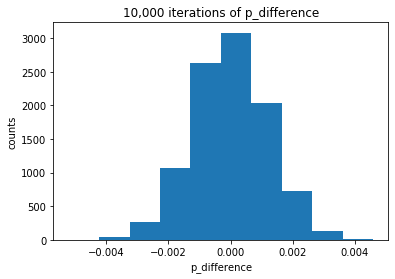

In [189]:
# Here we will plot to see the disterbution.
plt.hist(p_diffs)
plt.xlabel('p_difference')
plt.ylabel('counts')
plt.title('10,000 iterations of p_difference');

#### Yes, it is looks normally distributed.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [190]:
# We will compute the actual difference between the individuals who converted to new page and the ones who converted to old page.
actual_diffs = treatment_converted - control_converted
actual_diffs

-0.0015782389853555567

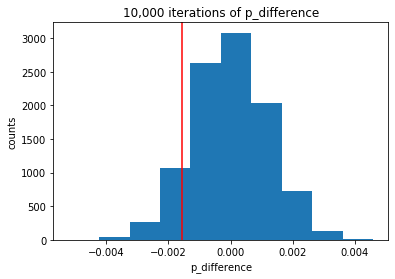

In [191]:
# we will plot to see where is the actual difference.
plt.hist(p_diffs)
plt.axvline(actual_diffs, c= 'red')
plt.xlabel('p_difference')
plt.ylabel('counts')
plt.title('10,000 iterations of p_difference');

In [192]:
p_diffs = np.array(p_diffs)
(p_diffs > actual_diffs).mean()

0.9027

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

#### What we aim here is to reject the null hypothesis by proving that the new page is better than the old page, in oreder to do that the p-value must be less than or equal to the Type I error rate of 5% or greater than 95%. We can see that from the result we fail to reject the null hypothesis.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [193]:
import statsmodels.api as sm

# Here we need to know the total number of conversion for each page 
convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
# Here we will count the number of each groups.
n_old = df2[df2['group']== 'control'].count()[0]
n_new = df2[df2['group']== 'treatment'].count()[0]

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [194]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative ='smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

#### Yes, after we calculated the z_score and p_value we can confirm that, we fail to reject the null hypothesis, since p_value is not greater than 0.95. Therefore we do agree with the findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

#### Since we are dealing with only two outcomes, we will use the Logistic Regression.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [195]:
# We can use the above stats model to preform and fit the logistic regression.

df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'],prefix='group').iloc[:, 1:]

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [196]:
lr = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lr.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [197]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               8.077e-06
Time:                        18:29:35   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

#### The p-value = 0.190 and since it is greater than 0.05 (Type I error rate), we will fail to reject the null hypothesis. In regression modelthe hypothesis test for each x-variable is a test of if that population slope is equal to zero vs. an alternative where the parameter differs from zero.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

#### Using regression in hypothesis tests to see correlation coefficients, these tests help us determine if there is a statistically significant linear relationship between a particular variable and the response. The hypothesis test for the intercept isn't useful in most cases. We can say that there is a disadvantage if we use different sample data may show some differences.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [198]:
countries_df = pd.read_csv('countries.csv')
df3 = pd.merge(df2, countries_df,how ='inner',on ='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [199]:
# We will use the dummy variables for the countries 
df3['intercept'] = 1
df3[['US', 'UK']] = pd.get_dummies(df3['country'])[['US', 'UK']]
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,1,0


In [200]:
lr2 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK']])
results2 = lr2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               2.323e-05
Time:                        18:29:37   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

#### As per the above results we fail to reject our null hypothesis since the p-value is greater than 0.05 or less than 0.95 . Therefore we will accept the old page is better or equal to new page(null hypothesis). We can see that in comparison, p-value for UK shows that it is a slightly better than US, that's mean the user in UK is more likely to convert more than the user in US.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [201]:
# Here we will find the intersection betweemn countries and ab_page.
df3['US_conversion'] = df3['US']*df3['ab_page']
df3['UK_conversion'] = df3['UK']*df3['ab_page']

In [202]:
lr3 = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'US', 'UK','US_conversion', 'UK_conversion']])
results2 = lr3.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 24 Jun 2020   Pseudo R-squ.:               3.482e-05
Time:                        18:29:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept        -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page          -0.0674      0.052     -1.297      0.195      -0.169       0.034
US                0.0175      0.038      0.465      0.642      -0.056       0.091
UK                0.0118      0.040      0.296      0.767      -0.066       0.090
US_conversion     0.0469      0.054      0.872      0.383      -0.059       0.152
UK_conversion     0.0783      0.057      1.378      0.168      -0.033       0.190
=================================================================================
"""

#### Here as well we can conclude from the above results we fail to reject our null hypothesis since the p-value is greater than 0.05 or less than 0.95 . Therefore we will accept the old page is better or equal to new page(null hypothesis).

#### After the intersction we can see that depending on the page there is a slightly effect, in comparison of p-value for UK_conversion shows that it is a slightly better than US_conversion, that's mean the user in UK is more likely to convert more than the user in US.

<a id='conclusions'></a>



In [203]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0